# This notebook processes two sets of raw data for later analysis
## 1. MTA NYCT Bus Data
- The data is downloaded with [fetchbus.py](https://github.com/ywnch/NYC-bus-LTT-prediction/blob/master/fetchbus.py) from MTA SIRI API.
- Training Data Time Range: 2018/04/06 to 2018/04/12 and 16:00 to 20:00 (evening peak for a week)
- Training Data Space Range: "5 AV/EAST 94 ST" to "5 AV/W 36 ST" (CallDistanceAlongRoute: 4843.9 ~ 9554.96)
- Training Data Direction: Southbound (DirectionRef: 1)

## 2. MiM Traffic Flow Data
- Manually downloaded from [NYC DOT website](http://flowmap.nyctmc.org/weborb4/flowmap/)
- Time Range: same as above
- Space Range: same as above
- See metadata documented [here](https://github.com/ywnch/NYC-bus-LTT-prediction/blob/master/data/traffic-metadata.csv)
- The only variable is travel time

## Variables for MTA NYCT Bus Data
### Manually generated:
- DayOfWeek - 1: Monday; 7: Sunday
- VehicleDistanceAlongRoute - The distance of the vehicle from the beginning of the trip/route in meters. ("CallDistanceAlongRoute" minus "DistanceFromCall")

### API variables:
- Bearing – Vehicle bearing: 0 is East, increments counter-clockwise.
- BlockRef – Depending on the system’s level of confidence, the GTFS block_id the bus is serving. Please see “Transparency of Block vs. Trip-Level Assignment”.
- CallDistanceAlongRoute -The distance of the stop from the beginning of the trip/route in meters.
- DataFrameRef – The GTFS service date for the trip the vehicle is serving.
- DatedVehicleJourneyRef – The GTFS trip ID for trip the vehicle is serving, preceeded by the GTFS agency ID.
- DestinationRef – The GTFS stop ID for the last stop on the trip the vehicle is serving, prefixed by Agency ID.
- DirectionRef – The GTFS direction for the trip the vehicle is serving.
- DistanceFromCall – The distance from the vehicle to the stop along the route, in meters.
- Distances – The MTA Bus Time extensions to show distance of the vehicle from the stop.
- Extensions – SIRI container for extensions to the standard.
- FramedVehicleJourneyRef – A compound element uniquely identifying the trip the vehicle is serving.
- JourneyPatternRef – The GTFS Shape ID, prefixed by GTFS Agency ID.
- LineRef – The ‘fully qualified’ route name (GTFS agency ID + route ID) for the trip the vehicle is serving. Not intended to be customer-facing.
- Monitored – Always true.
- MonitoredCall – Call data about a particular stop. In StopMonitoring, it is the stop of interest, in VehicleMonitoring it is the next stop the bus will make.
- MonitoredStopVisit– SIRI container for data about a particular vehicle servicing the selected stop.
- MonitoredVehicleJourney – A MonitoredVehicleJourney element for a vehicle in revenue service. Please See the MonitoredVehicleJourney page for a thorough discription.
- OnwardCall – A stop that the vehicle is going to make.
- OnwardCalls – The collection of calls that a vehicle is going to make.
- OperatorRef – GTFS Agency_ID.
- OriginAimedDepartureTime – OriginAimedDepartureTime indicates the scheduled departure time of that bus from that terminal in ISO8601 format.
- OriginRef -The GTFS stop ID for the first stop on the trip the vehicle is serving, prefixed by Agency ID
- PresentableDistance -The distance displayed in the UI, see below for an additional info.
- ProgressRate – Indicator of whether the bus is making progress (i.e. moving, generally), not moving (with value noProgress), laying over before beginning a trip (value layover), or serving a trip prior to one which will arrive (prevTrip).
- ProgressStatus – Optional indicator of vehicle progress status. Set to “layover” when the bus is in a layover waiting for its next trip to start at a terminal, and/or “prevTrip” when the bus is currently serving the previous trip and the information presented ‘wraps around’ to the following scheduled trip.
- PublishedLineName – The GTFS route_short_name.
- RecordedAtTime – The timestamp of the last real-time update from the particular vehicle.
- ResponseTimestamp – The timestamp on the MTA Bus Time server at the time the request was fulfilled.
- SituationExchangeDelivery – The SIRI SituationExchangeDelivery element only appears when there is a service alert active for a route or stop being called on. It is used by the responses to both the VehicleMonitoring and StopMonitoring calls.
- SituationRef – SituationRef, present only if there is an active service alert covering this call.
- StopMonitoringDelivery – SIRI container for VehicleMonitoring response data
- StopPointName – The GTFS stop name of the stop.
- StopPointRef – The GTFS stop ID of the stop prefixed by agency_id.
- StopsFromCall – The number of stops on the vehicle’s current trip until the stop in question, starting from 0.
- ValidUntil – The time until which the response data is valid until.
- VehicleActivity – SIRI container for data about a particular vehicle.
- VehicleLocation – The most recently recorded or inferred coordinates of this vehicle.
- VehicleMonitoringDelivery – SIRI container for VehicleMonitoring response data.
- VehicleRef – The vehicle ID, preceded by the GTFS agency ID.
- VisitNumber – The ordinal value of the visit of this vehicle to this stop, always 1 in this implementation.

#### Transparency of Block vs. Trip-Level Assignment:

MTA Bus Time tries to assign buses to blocks- a sequence of trips that start and end at a depot. This allows the system to make a statement about what a bus will do after it reaches the end of its current trip.

However, there is not always enough affirmative and corresponding evidence to make such a strong statement. In this case, MTA Bus Time falls back to a trip-level assignment, where it just picks a trip from the schedule that is representative of the route and stopping pattern that the bus is likely to pursue.

The SIRI API now reflects this distinction as described here and in other items below. If the assignment is block-level, the new BlockRef field of the MonitoredVehicleJourney is present, and populated with the assigned block id.

#### The PresentableDistance field:

the logic that determines whether stops or miles are shown in the PresentableDistance field is below:

show distance in miles if and only if:
(distance in miles to _immediate next stop_ is > D) OR (distance in stops to current stop is > N AND distance in miles to current stop > E)
in other words, show distance in stops if and only if (the below is just the inverse of the above, according to DeMorgan’s law):
(distance in miles to _immediate next stop_ is <= D) AND (distance in stops to current stop <= N OR distance in miles to current stop <= E)
Show “approaching” if and only if:
distance_in_miles to immediate next stop < P
show “at stop” if and only if:
distance_in_miles to immediate next stop < T
Current Parameter Values:

Parameter Value (Note that distances in the data are in **METERS**)
- D .5 miles
- N 3 stops
- E .5 miles
- P 500 feet
- T 100 feet

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1. MTA NYCT Bus Data

In [2]:
# raw data
fnames = ["data/M1-Fri-180406-154257-260.csv",
          "data/M1-Sat-180407-154620-260.csv",
          "data/M1-Sun-180408-155956-250.csv",
          "data/M1-Mon-180409-155534-250.csv",
          "data/M1-Tue-180410-154415-260.csv",
          "data/M1-Wed-180411-155909-250.csv",
          "data/M1-Thu-180412-154116-260.csv"]

In [3]:
def process(fname):
    """
    Subset M1 data for 16:00 - 20:00, southbound,
    and between E 94 - W 36 on 5 Av.
    """
    
    # read fetchbus output dataframe
    df = pd.read_csv(fname)

    # remove redundant column
    df.drop('Unnamed: 0', axis=1, inplace=True)
    
    # subset for direction 1
    df = df[df['DirectionRef'] == 1]
    
    # convert to local timezone
    df['Timestamp'] = pd.to_datetime(df['RecordedAtTime']) \
                        .dt.tz_localize('UTC') \
                        .dt.tz_convert('America/New_York')

    # generate day of week variable
    df['DayOfWeek'] = df['Timestamp'].dt.dayofweek + 1
    
    # set timestamp as index and subset within 1600 to 2000 time window
    df = df.set_index('Timestamp').between_time('16:00', '20:00')

    # calculate vehicle distance
    df['VehicleDistanceAlongRoute'] = df['CallDistanceAlongRoute'] - df['DistanceFromCall']
    
    # subset for MiM data available segement (4843:9555)
    df = df[(df['VehicleDistanceAlongRoute'] > 4843) & (df['VehicleDistanceAlongRoute'] < 9555)]
    
    # sort dataframe
    df.sort_index(inplace=True)
    
    # return df
    return df

In [4]:
dfs = []

# save individual modified data
for i, f in enumerate(fnames):
    df = process(f)
    dfs.append(df)
    df.to_csv("data/M1-%s.csv"%(180406+i))

# concat all data into a single file as well
df_all = pd.concat(dfs)
df_all.to_csv("M1-train.csv")

In [5]:
df_all.head()

,Bearing,BlockRef,CallDistanceAlongRoute,DataFrameRef,DatedVehicleJourneyRef,DestinationName,DestinationRef,DirectionRef,DistanceFromCall,ExpectedArrivalTime,...,ProgressStatus,PublishedLineName,RecordedAtTime,StopPointName,StopPointRef,StopsFromCall,VehicleRef,VisitNumber,DayOfWeek,VehicleDistanceAlongRoute
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-06 16:00:01-04:00,233.35362,MTA NYCT_OF_B8-Weekday_C_OF_29220_M1-122,5169.49,2018-04-06,MTA NYCT_OF_B8-Weekday-092900_M1_145,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,23.58,2018-04-06T16:00:18.763-04:00,...,NaN,M1,2018-04-06T16:00:01.000-04:00,5 AV/EAST 90 ST,MTA_400117,0,MTA NYCT_3891,1,5,5145.91
2018-04-06 16:00:04-04:00,233.75014,MTA NYCT_OF_B8-Weekday_C_OF_20820_M1-105,8868.91,2018-04-06,MTA NYCT_OF_B8-Weekday-089200_M1_140,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,77.74,2018-04-06T16:00:53.260-04:00,...,NaN,M1,2018-04-06T16:00:04.000-04:00,5 AV/W 45 ST,MTA_405179,0,MTA NYCT_3901,1,5,8791.17
2018-04-06 16:00:07-04:00,234.19359,MTA NYCT_OF_B8-Weekday_C_OF_54660_M1-146,6718.93,2018-04-06,MTA NYCT_OF_B8-Weekday-091400_M1_146,E VILLAGE 8 ST via 5 AV,MTA_403793,1,48.54,2018-04-06T16:00:22.288-04:00,...,NaN,M1,2018-04-06T16:00:07.000-04:00,5 AV/E 72 ST,MTA_400124,0,MTA NYCT_3898,1,5,6670.39
2018-04-06 16:00:08-04:00,234.03671,MTA NYCT_OF_B8-Weekday_C_OF_28980_M7-204,8227.92,2018-04-06,MTA NYCT_OF_B8-Weekday-089800_M7_207,E VILLAGE 8 ST via 5 AV,MTA_403793,1,30.32,2018-04-06T16:00:20.005-04:00,...,NaN,M1,2018-04-06T16:00:08.000-04:00,5 AV/W 53 ST,MTA_400514,0,MTA NYCT_3889,1,5,8197.60
2018-04-06 16:00:11-04:00,233.93703,MTA NYCT_OF_B8-Weekday_C_OF_18120_M1-102,9554.96,2018-04-06,MTA NYCT_OF_B8-Weekday-088600_M7_225,GRAND STREET via 5 AV/BROADWAY,MTA_803192,1,2.96,2018-04-06T16:00:18.763-04:00,...,NaN,M1,2018-04-06T16:00:11.000-04:00,5 AV/W 36 ST,MTA_400323,0,MTA NYCT_3903,1,5,9552.00


## 2. MiM Traffic Flow Data

In [6]:
# read metadata of segment info
metadata = pd.read_csv("data/traffic-metadata.csv")
metadata

,ID,from,to,segment,meter,feet
0,188189,188,189,5th Avenue - Southbound - 96th St to 86th St,811.76,2663.22
1,18922,189,22,5th Avenue - Southbound - 86th St to 72nd St,1153.06,3782.96
2,2216,22,16,5th Avenue - Southbound - 72nd St to 57th St,1207.64,3962.03
3,1615,16,15,5th Avenue - Southbound - 57th St to 49th St,642.36,2107.45
4,1514,15,14,5th Avenue - Southbound - 49th St to 42nd St,564.20,1851.03
5,14118,14,118,5th Avenue - Southbound - 42nd St to 34th St,642.87,2109.13


In [7]:
dfs = []

# add segment ID to each data file
for i, n in enumerate(metadata['ID']):
    for d in range(7):
        df = pd.read_csv("data/%s_mim_data_04_%02d_18.csv"%(n, 6+d))
        df['ID'] = n
        dfs.append(df)

# concat all data
df_all = pd.concat(dfs)

# drop duplicates of same datetime at the same segment (keep the latest record)
df_all.drop_duplicates(['Date', 'time', 'ID'], keep='last', inplace=True)

# save into a single file
df_all.reset_index(drop=True, inplace=True)
df_all.to_csv("mim-train.csv")

In [8]:
df_all.head()

,uid,Date,time,travelTime,ID
0,1352824837,04-06-18,16:00:00,320,188189
1,1352825102,04-06-18,16:00:15,275,188189
2,1352825304,04-06-18,16:00:27,180,188189
3,1352826723,04-06-18,16:01:58,184,188189
4,1352827945,04-06-18,16:03:11,243,188189


## Plot Time-space Diagram

In [1]:
from fetchbus import plot_tsd

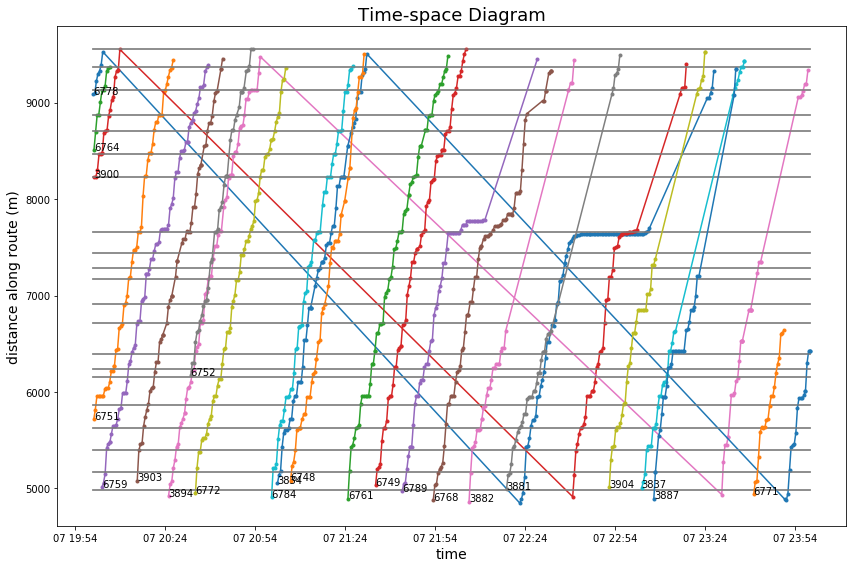

(<matplotlib.figure.Figure at 0x10e200fd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x115963be0>)

In [8]:
df = pd.read_csv("M1-train.csv")
df = df[df['DayOfWeek'] == 6]
plot_tsd(df, dir_ref=1)